> Mendicant Bias V4, le añadiré Segmentación semántica para crear máscaras de atención para una mejora en sus resultados y sobre todo, en lo que se enfoca completamente.
>
>__Nota__: Igual que Mendicant Bias V3, trataré de NO usar modelos preentrenados y/o hacer Transfer Learning de algún modelo que ya sea famoso

In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.nn import functional
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
import pandas as pd
import numpy as np
from PIL import Image
import os
import random
import matplotlib.pyplot as plt

> Primero vamos con los datos, en este caso usaremos otro Dataset que es el Oxford-IIIT Pet Dataset. 


In [2]:
#print("Descargando el dataset oficial con máscaras...")
#dataset = OxfordIIITPet(root='../../PetImages/New_DS/data', split='trainval', target_types='segmentation', download=True)

#print(f"¡Listo! Se descargaron {len(dataset)} imágenes con sus máscaras.")

In [3]:
from tqdm import tqdm

def checkMask(directory:str):
    files = [f for f in os.listdir(directory) if f.endswith(".png") or f.endswith(".jpg")]
    values_found = set()

    for archivo in tqdm(files[:400]):
        mask = Image.open(os.path.join(directory, archivo)).convert("L")
        mask_np = np.array(mask)
        uniques = np.unique(mask_np)

        for valor in uniques:
            values_found.add(valor)
        
    print(f"Valores encontrados: {values_found}")
    return values_found

In [4]:
valores = checkMask("../../OXFORD_CLEAN/masks/")

100%|██████████| 400/400 [00:00<00:00, 817.11it/s]

Valores encontrados: {np.uint8(0), np.uint8(1), np.uint8(2)}


In [5]:

def checkImages(df, img_dir, mask_dir, num_muestras=3):
    indices = random.sample(range(len(df)), num_muestras)
    
    for idx in indices:
        img_name = df.iloc[idx, 0]
        mask_name = df.iloc[idx, 1]
        
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)
        
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') # Importante verla como viene
        
        mask_np = np.array(mask)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(img)
        ax[0].set_title("Imagen Original")
        ax[0].axis('off')
        
        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title(f"Máscara Raw (Valores: {np.unique(mask_np)})")
        ax[1].axis('off')
        
        #'jet' asigna colores distintos a números cercanos
        cax = ax[2].imshow(mask_np, cmap='jet') 
        ax[2].set_title("Máscara Coloreada (Visualización)")
        ax[2].axis('off')
        
        #Barra de colores
        plt.colorbar(cax, ax=ax[2], ticks=np.unique(mask_np))
        plt.show()

Arquitectura de máscaras de atención hechas con una implementación de ResNet, una... tipo ResU - Net

In [6]:
def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = stride, padding = 1, bias = False)

class BloqueResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample=None):
        super(BloqueResidual, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, stride = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSampling, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias = False)
        self.bn = nn.BatchNorm2d(out_channels, affine=True)
        self.downsample_res = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.refine = BloqueResidual(out_channels * 2, out_channels, downsample=self.downsample_res)

    def forward(self, x, skip_connection):
        x = self.bn(self.up(x))
        x = torch.cat([x, skip_connection], dim = 1)
        x = self.refine(x)
        return x
        
class MendicantBiasV4(nn.Module):
    def __init__(self, num_clases = 3):
        super(MendicantBiasV4, self).__init__()

        self.in_channels = 64
        self.downsample = None
        
        # > Bajadaaaaaaaaaaaaaaaaaaa

        #No es tan agresiva la entrada a la ResU-Net
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding = 1, bias = False), #3, 64, 128, 128 -> 64, ...
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True)
        )

        self.layer1 = self._hacer_capaXD(64, 3, 1)

        self.layer2 = self._hacer_capaXD(128, 3, 2)

        self.layer3 = self._hacer_capaXD(256, 3, 2)

        self.layer4 = self._hacer_capaXD(512, 3, 2)
        
        self.up1 = UpSampling(512, 256)
        
        self.up2 = UpSampling(256, 128)

        self.up3 = UpSampling(128, 64)

        self.head = nn.Conv2d(64, num_clases, kernel_size=1)
            
    def _hacer_capaXD(self, out_channels, bloques, stride = 1):

        #El downsamples broooooooo
        if (stride != 1) or (self.in_channels != out_channels):
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels, affine=True)
            )
        
        layers = []

        layers.append(BloqueResidual(self.in_channels, out_channels, stride, self.downsample))

        self.in_channels = out_channels

        for _ in range(1, bloques):
            layers.append(BloqueResidual(self.in_channels, out_channels, stride = 1))
        
        return nn.Sequential(*layers)
         
    def forward(self, x):
        x0 = self.stem(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1) 
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.head(x)
        return logits



In [7]:
df = pd.read_csv('../../Labels/dataset.csv')
df

,file,mask
0,Abyssinian_1.jpg,Abyssinian_1.png
1,Abyssinian_10.jpg,Abyssinian_10.png
2,Abyssinian_100.jpg,Abyssinian_100.png
3,Abyssinian_101.jpg,Abyssinian_101.png
4,Abyssinian_102.jpg,Abyssinian_102.png
...,...,...
7385,yorkshire_terrier_95.jpg,yorkshire_terrier_95.png
7386,yorkshire_terrier_96.jpg,yorkshire_terrier_96.png
7387,yorkshire_terrier_97.jpg,yorkshire_terrier_97.png
7388,yorkshire_terrier_98.jpg,yorkshire_terrier_98.png


In [8]:
df["raza"] = df['file'].apply(lambda x: "_".join(x.split("_")[:-1])) 
#Acá dice primero separame por " _ ", sería ["Abyssinian", "1.jpg"], ahora quiero que agarres todo, menos el último elemento
#Entonces nos queda: ["Abyssinian"], por lo que ahora unelo, pero con _ en cada elemento, pero como es uno solo, queda exactamente igual
df

,file,mask,raza
0,Abyssinian_1.jpg,Abyssinian_1.png,Abyssinian
1,Abyssinian_10.jpg,Abyssinian_10.png,Abyssinian
2,Abyssinian_100.jpg,Abyssinian_100.png,Abyssinian
3,Abyssinian_101.jpg,Abyssinian_101.png,Abyssinian
4,Abyssinian_102.jpg,Abyssinian_102.png,Abyssinian
...,...,...,...
7385,yorkshire_terrier_95.jpg,yorkshire_terrier_95.png,yorkshire_terrier
7386,yorkshire_terrier_96.jpg,yorkshire_terrier_96.png,yorkshire_terrier
7387,yorkshire_terrier_97.jpg,yorkshire_terrier_97.png,yorkshire_terrier
7388,yorkshire_terrier_98.jpg,yorkshire_terrier_98.png,yorkshire_terrier


In [9]:
#  Ahora ocupamos dividir el dataset para tener los datos de entrenamiento, validación y dev

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['raza'],
    random_state=20
)

val_df, dev_df = train_test_split(
    val_df,
    test_size=0.1,
    stratify=val_df['raza'],
    random_state=20
)

print(len(train_df), len(val_df), len(dev_df))

5912 1330 148


AHORA SI CHECAMOS LAS IMAGENES XD

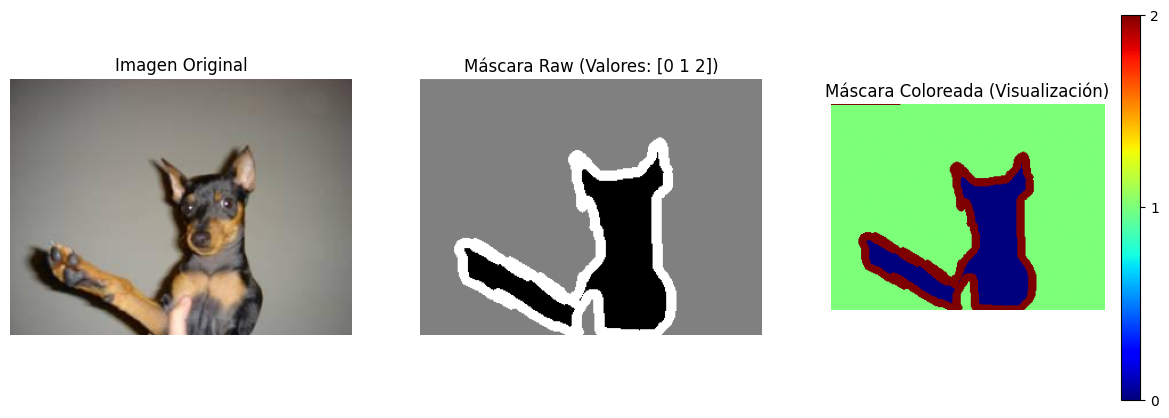

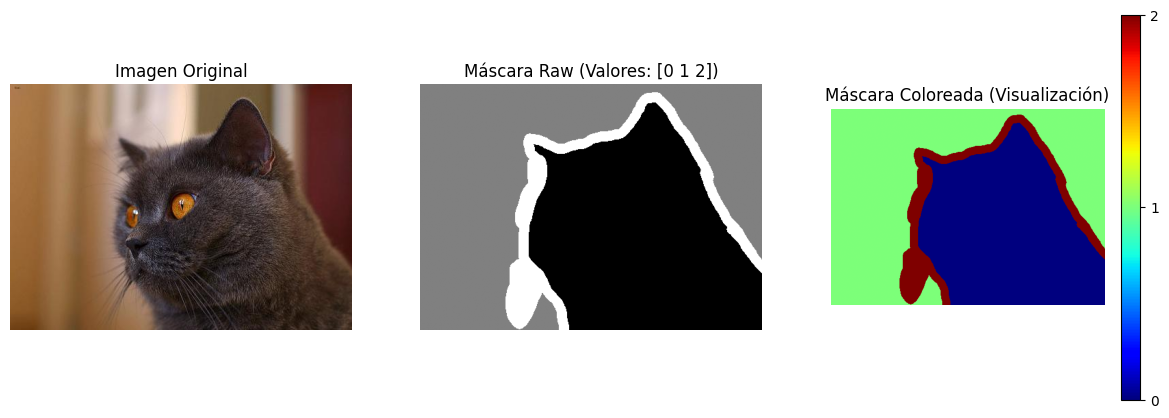

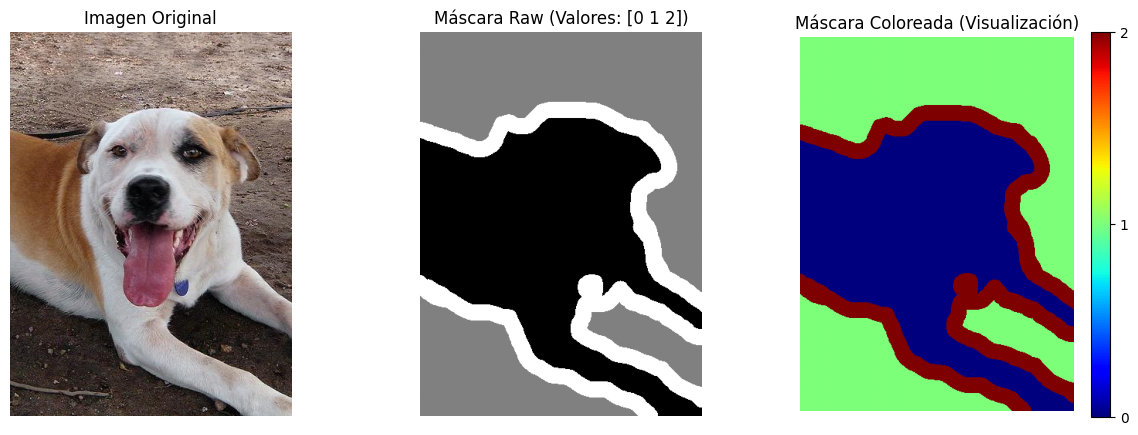

In [10]:
checkImages(train_df, "../../OXFORD_CLEAN/images/", "../../OXFORD_CLEAN/masks//")

In [11]:
# Acá andaba investigando, porque no sé muy bien como hacer un dataset -> dataloader para una segmentación, por lo que ví que usan la misma transformación para las máscaras y imagen
# Esto debido a que si rotas 10 grados la máscara de segmentación, pero no giras la imagen, termina aprendiendo basura el modelo.
# Lo anterior de la raza, no me interesa mucho porque solo quiero que este modelo segmente las imágenes y esas son las que haré para entrenar mi modelo Mendicant Bias V4

import numpy as np
from torchvision.transforms import InterpolationMode

class CustomDS(Dataset):
    def __init__(self, dataframe, img_dir, mask_dir, transformador = None):
        self._dataframe = dataframe
        self._img_dir = img_dir
        self._mask_dir = mask_dir
        self._transformador = transforms.Compose([
            transforms.Resize((192, 192)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self._dataframe)

    def __getitem__(self, idx):
        image_path = self._dataframe.iloc[idx, 0]
        mask_path = self._dataframe.iloc[idx, 1]
        img_path = os.path.join(self._img_dir, image_path)
        maskPath = os.path.join(self._mask_dir, mask_path)
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(maskPath)

        img = self._transformador(img)
        mask = transforms.functional.resize(mask, (192, 192), interpolation=InterpolationMode.NEAREST) 

        mask_np = np.array(mask)
        mask_tensor = torch.from_numpy(mask_np).long()
        mask_tensor = torch.clamp(mask_tensor, 0, 2)
        return img, mask_tensor
    

#Datasets
train_ds = CustomDS(train_df, "../../OXFORD_CLEAN/images/", "../../OXFORD_CLEAN/masks/")
val_ds = CustomDS(val_df, "../../OXFORD_CLEAN/images/", "../../OXFORD_CLEAN/masks/")
dev_ds = CustomDS(dev_df, "../../OXFORD_CLEAN/images/", "../../OXFORD_CLEAN/masks/")

#DataLoaders
train_dl = DataLoader(train_ds, batch_size=8, shuffle = True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle = True, num_workers=0, pin_memory=True)
dev_dl = DataLoader(dev_ds, batch_size=8, shuffle = True, num_workers=0, pin_memory=True)

In [13]:
Mendicant_BiasV4 = MendicantBiasV4()

MendicantBiasV3_Weights = torch.load('./Models/Mendicant_BiasV3.pth')

state_V4 = Mendicant_BiasV4.state_dict()
state_V4

pesos_a_transferir = {k: v for k, v in MendicantBiasV3_Weights.items() if k in state_V4 and v.size() == state_V4[k].size()}

print(f"Transfiriendo {len(pesos_a_transferir)} capas del V3 al V4...")

state_V4.update(pesos_a_transferir)
Mendicant_BiasV4.load_state_dict(state_V4)

Transfiriendo 119 capas del V3 al V4...


<All keys matched successfully>

In [14]:
def train_model(modelo, dataloaders:list, optimizador, loss_function, scheduler, device, dia):
    
    history = {}

    if modelo and isinstance(dataloaders, list):
        
        modelo.to(device)

        best_accuracy = 0.0
        train_dl, val_dl = dataloaders
        epochs = 20

        print("Iniciando entrenamiento")

        for i in range(1, epochs + 1):
            #Métricas
            train_loss_acc = 0.0
            train_correct_pixels = 0
            train_total_pixels = 0

            #Modelo en modo de entrenamiento wachin
            modelo.train()
            for image, mask in train_dl:
                image, mask = image.to(device), mask.to(device)

                optimizador.zero_grad()
                output = modelo(image) # [Batch, 3, 512, 512]
                
                loss = loss_function(output, mask) # Mask debe ser [Batch, 512, 512] (Long)
                loss.backward()
                optimizador.step()

                train_loss_acc += loss.item()
                
                # Precisión de Píxeles (Train)
                _, preds = torch.max(output, 1) # Obtenemos el índice de la clase ganadora
                train_correct_pixels += (preds == mask).sum().item()
                train_total_pixels += mask.numel() # Total de píxeles en el batch

            train_loss = train_loss_acc / len(train_dl)
            train_acc = (train_correct_pixels / train_total_pixels) * 100

            actual_valLoss = 0.0
            val_correct_pixels = 0
            val_total_pixels = 0

            modelo.eval()
            with torch.no_grad():
                for image, mask in val_dl:
                    image = image.to(device)
                    mask = mask.to(device)
                    
                    #Predicción
                    predict = modelo(image)
                    val_loss = loss_function(predict, mask)

                    #Acumular loss
                    actual_valLoss += val_loss.item()

                    _, predicts = torch.max(predict, 1) #Acá podes ver la confianza de predicción con confianza en lugar de _

                    val_correct_pixels += (predicts == mask).sum().item()
                    val_total_pixels += mask.numel()
                
            avg_val_loss = actual_valLoss / len(val_dl)
            val_acc = (val_correct_pixels / val_total_pixels) * 100

            if scheduler:
                scheduler.step(avg_val_loss)
            
            if val_acc > best_accuracy:
                torch.save(modelo.state_dict(), fr'Models/ModeloPrueba{dia}.pth')
                best_accuracy = val_acc
                print(f"--> Nuevo mejor modelo con acc: {best_accuracy:.2f}")

            history[i] = {
                "train_loss":train_loss,
                "train_acc":train_acc, 
                "val_loss":val_loss,
                "val_acc":val_acc
                }
            
            print(f"Epoch {i}: Train Loss = {train_loss:.4f}; Precision = {train_acc:.4f};Validation loss = {val_loss:.4f}, Precisión = {val_acc:.4f}%")


In [15]:
from datetime import date

dia = date.today()
print(dia)

2025-12-25


In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
seg = MendicantBiasV4(num_clases=3)
optimizador = torch.optim.Adam(params=seg.parameters(), lr=1e-3 , weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizador, mode="min", factor=0.1, patience = 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#train_model(seg, dataloaders=[train_dl, val_dl], optimizador = optimizador,loss_function=loss_fn, scheduler = None, device = device, dia = dia)

In [17]:
def overfit_single_batch(modelo, train_dl, device):
    print("Iniciando prueba")
    
    # Tomamos UN solo batch de datos
    image, mask = next(iter(train_dl))
    image, mask = image.to(device), mask.to(device)
    
    modelo.to(device)
    modelo.train()
    
    optimizer = torch.optim.Adam(modelo.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    for i in range(100): # 100 iteraciones sobre la MISMA imagen
        optimizer.zero_grad()
        output = modelo(image)
        loss = loss_fn(output, mask)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f"Iter {i}: Loss = {loss.item():.4f}")
            
            if loss.item() < 0.5:
                print("El modelo está aprendiendo.")
                return True
                
    print("El modelo no aprende.")
    return False

# EJECUTA ESTO
overfit_single_batch(Mendicant_BiasV4, train_dl, device)

Iniciando prueba
Iter 0: Loss = 1.1248
Iter 10: Loss = 0.4214
El modelo está aprendiendo.


True

In [18]:
def DevTest(modelo, dev_dl, loss_fn, device) -> float:
    modelo.eval()
    modelo = modelo.to(device)
    actual_loss = 0.0
    actual_correct_pixels = 0
    actual_total_pixels = 0
    with torch.no_grad():
        for image, mask in dev_dl:
            image, mask = image.to(device), mask.to(device)

            pred = modelo(image)
            loss = loss_fn(pred, mask)

            actual_loss += loss.item()
            _, preds = torch.max(pred, dim = 1)

            actual_correct_pixels += (preds == mask).sum().item()
            actual_total_pixels += mask.numel()
        
        dev_loss = actual_loss / len(dev_dl)
        precision = (actual_correct_pixels / actual_total_pixels) * 100

        print(f"Error en dataloader de dev: {dev_loss:.2f}, con una precisión del {precision:.2f}%.")
        return dev_loss, precision

In [19]:
modelo_piloto = MendicantBiasV4()
modelo_piloto.load_state_dict(torch.load("Models/ModeloPrueba2025-12-17.pth", weights_only=True))


<All keys matched successfully>

In [20]:
dev_loss, precision = DevTest(modelo_piloto, dev_dl, loss_fn, device)

Error en dataloader de dev: 0.38, con una precisión del 86.69%.


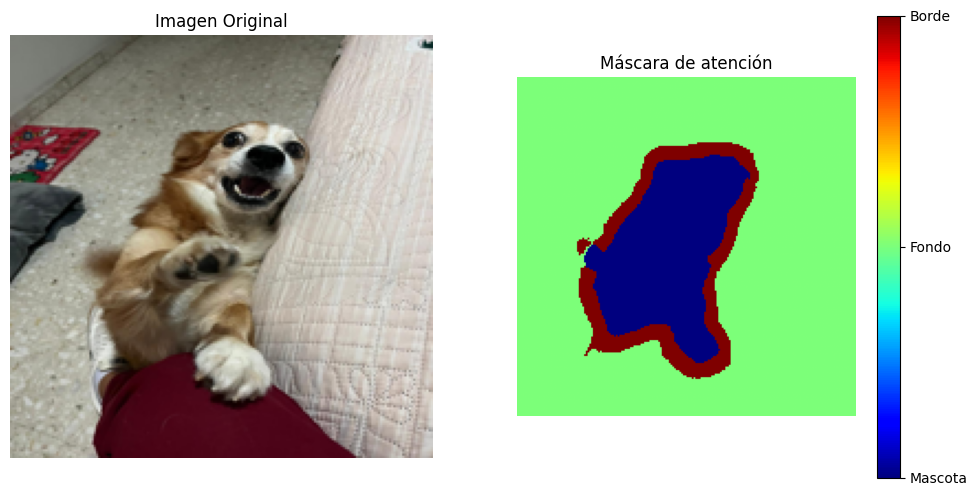

In [21]:


def predict(modelo, dir_path, file_path, device):
    modelo.eval()
    modelo = modelo.to(device)
    img_path = os.path.join(dir_path, file_path)
    
    img = Image.open(img_path).convert('RGB')
    tf = transforms.Compose([
        transforms.Resize((192, 192)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

    img_tensor = tf(img)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = modelo (img_tensor)
        pred = torch.argmax(output, dim = 1) #torch.Size([1, 192, 192])
        pred_np = pred.squeeze(0).cpu().numpy()
    
    ig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Imagen Original (Redimensionada para que cuadre visualmente)
    ax[0].imshow(img.resize((192, 192))) 
    ax[0].set_title("Imagen Original")
    ax[0].axis('off')
    
    # Predicción (Mapa de Calor)
    # cmap='viridis' o 'jet' ayudan a diferenciar: 0 (fondo), 1 (mascota), 2 (borde)
    cax = ax[1].imshow(pred_np, cmap='jet', vmin=0, vmax=2)
    ax[1].set_title("Máscara de atención")
    ax[1].axis('off')
    
    # Barra de colores para entender qué es qué
    cbar = plt.colorbar(cax, ax=ax[1], ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Mascota', 'Fondo', 'Borde']) 
    
    plt.show()

predict(modelo_piloto, "../../PetImages/Old_DS/Dog/", "Perro.jpeg", device)


Ahora en base a lo que he platicado con Gemini e investigado, descubrí que puedo usar multiples funciones de pérdida, aunque aumenta la complejidad del código, lo hace mejor para segmentación, porque además puedo usar la DICE LOSS.

Más que nada la Generalised Dice Loss del paper con URL: https://arxiv.org/pdf/1707.03237



Ahora... dicha función requiere que las etiquetas o labels esten en formato one-hot encoding, porque si están en formato label encoding, no jala xd

Por lo que vamos a computar la función pa' que haga ese proceso

In [22]:
def one_hot(label, classes:list = ["Mascota", "Fondo", "Borde"]):
    _my_dict = {x: i for i, x in enumerate(classes)}

    vector = np.zeros(len(classes))

    idx = _my_dict[label]

    vector[idx] = float(1)

    return vector

print(one_hot("Borde")) #Prueba

[0. 0. 1.]


PD: NO SABNÍA QUE EXISTIA UN ONE-HOT ENCODING POR PARTE DE PYTORCH JAJAAJAJ soy pelotudo, además eso no funciona para DiceLoss mimimimi

In [23]:
def one_hot_encoding(target, num_clases):
    return torch.functional.F.one_hot(target, num_clases).permute(0, 3, 1, 2).float()

#Prueba
img, mask = next(iter(train_dl))

print(one_hot_encoding(mask, 3))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [24]:
class GeneralizedDiceLoss(nn.Module):
    def __init__(self, epsilon = 1e-6): #En el paper nos dan el valor predeterminado de epsilon, pero lo paso como parametro opcional para cambiarlo si ocupo
        super().__init__()
        self.epsilon = epsilon
    
    def forward(self, input, target): #Input y target son tensores
        input = torch.functional.F.softmax(input, dim = 1)

        input = input.view(input.size(0), input.size(1), -1).float() #[B, C, P]
        target = one_hot_encoding(target, 3)

        volumenes = torch.sum(target, dim = (2, 3))
        w_c = 1.0 / (volumenes**2 + self.epsilon)

        target = target.view(target.size(0), target.size(1), -1).float() #[B, C, P]
        
        interseccion = torch.sum(input * target, dim = 2) #[B, C]

        union = torch.sum(input + target, dim = 2) #[B, C]

        numerador = torch.sum(w_c * interseccion, dim = 1) #[B]
        denominador = torch.sum(w_c * union, dim = 1) #[B]

        math_expression = 1 - 2 * (numerador / (denominador + self.epsilon))

        return math_expression.mean() #SOLO EL ESCALAR O EL PROMEDIO, NADA DE VECTORES

In [33]:
class AttentionGates(nn.Module):
    def __init__(self, f_g, f_l, F_int):
        super(AttentionGates, self).__init__()

        self.w_x = nn.Sequential(
            nn.Conv2d(in_channels=f_l, out_channels=F_int, kernel_size = 3, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(num_features=F_int, affine=True)
        )

        self.w_g = nn.Sequential(
            nn.Conv2d(in_channels=f_g, out_channels=F_int, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(num_features=F_int, affine = True)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(in_channels=F_int, out_channels = 1, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(num_features=1, affine = True)
        )

        self.relu = torch.nn.ReLU(inplace = True)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, gate, skip_connection):
        g1 = self.w_g(gate)
        x1 = self.w_x(skip_connection)

        if g1.shape[2:] != x1.shape[2:]:
            g1 = torch.nn.functional.interpolate(g1, size = x1.shape[2:], mode='NEAREST')

        psi = self.relu(g1 + x1)
        pre_sigmoid = self.psi(psi)
        probs = self.sigmoid(pre_sigmoid)
        out = torch.nn.functional.interpolate(probs, size = skip_connection.shape[2:], mode = 'bilinear', align_corners=True)
        return out * skip_connection

In [34]:
def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = stride, padding = 1, bias = False)

class BloqueResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample=None):
        super(BloqueResidual, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, stride = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSampling, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias = False)
        self.bn = nn.BatchNorm2d(out_channels, affine=True)
        self.downsample_res = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.refine = BloqueResidual(out_channels * 2, out_channels, downsample=self.downsample_res)

    def forward(self, x, skip_connection):
        x = self.bn(self.up(x))
        x = torch.cat([x, skip_connection], dim = 1)
        x = self.refine(x)
        return x
        
class Daowa_maad(nn.Module):
    def __init__(self, num_clases = 3):
        super(Daowa_maad, self).__init__()

        self.in_channels = 64
        self.downsample = None
        
        # > Bajadaaaaaaaaaaaaaaaaaaa

        #No es tan agresiva la entrada a la ResU-Net
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding = 1, bias = False), #3, 64, 128, 128 -> 64, ...
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True)
        )

        self.layer1 = self._hacer_capaXD(64, 3, 1)

        self.layer2 = self._hacer_capaXD(128, 3, 2)

        self.layer3 = self._hacer_capaXD(256, 3, 2)

        self.layer4 = self._hacer_capaXD(512, 3, 2)
        
        self.up1 = UpSampling(512, 256)

        self.attgate1 = AttentionGates(512, 256, 256)
        
        self.up2 = UpSampling(256, 128)

        self.attgate2 = AttentionGates(256, 128, 128)

        self.up3 = UpSampling(128, 64)
        
        self.attgate3 = AttentionGates(128, 64, 64)

        self.head = nn.Conv2d(64, num_clases, kernel_size=1)
            
    def _hacer_capaXD(self, out_channels, bloques, stride = 1):

        #El downsamples broooooooo
        if (stride != 1) or (self.in_channels != out_channels):
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels, affine=True)
            )
        
        layers = []

        layers.append(BloqueResidual(self.in_channels, out_channels, stride, self.downsample))

        self.in_channels = out_channels

        for _ in range(1, bloques):
            layers.append(BloqueResidual(self.in_channels, out_channels, stride = 1))
        
        return nn.Sequential(*layers)
         
    def forward(self, x):
        x0 = self.stem(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1) 
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x3_filtrada = self.attgate1(x4, x3)
        x = self.up1(x4, x3_filtrada)
        
        x2_filtrada = self.attgate2(x, x2)
        x = self.up2(x, x2_filtrada)

        x1_filtrada = self.attgate3(x, x1)
        x = self.up3(x, x1_filtrada)

        logits = self.head(x)
        return logits



In [35]:
Daowa = Daowa_maad(num_clases=3)
Daowa_dict = Daowa.state_dict()
Daowa_dict.update(pesos_a_transferir)
Daowa.load_state_dict(Daowa_dict)

<All keys matched successfully>

In [40]:
def train(modelo, dataloaders:list, optimizador, loss_functions:list, scheduler, device, dia):
    
    history = {}

    if modelo and isinstance(dataloaders, list):
        
        modelo.to(device)

        #Desempaquetado

        cross_fn, dice_fn = loss_functions

        train_dl, val_dl = dataloaders
        
        #Métricas
        epochs = 20
        best_accuracy = 0.0

        print("Iniciando entrenamiento")

        for i in range(1, epochs + 1):
            if 0 < i <= 5:
                #Métricas
                peso_dice = 0
                peso_cross = 1
            
            elif 5 < i <= 10: 
                #Métricas
                peso_dice = 0.5
                peso_cross = 0.5
            
            elif 10 < i <= 20:
                #Métricas
                peso_dice = 0.8
                peso_cross = 0.2
            
            #Métricas
            train_loss_acc = 0.0
            train_correct_pixels = 0
            train_total_pixels = 0

            #Modelo en modo de entrenamiento wachin
            modelo.train()
            for image, mask in train_dl:
                image, mask = image.to(device), mask.to(device)

                optimizador.zero_grad()
                output = modelo(image) # [Batch, 3, 512, 512]
                
                loss_cross = cross_fn(output, mask)
                loss_dice = dice_fn(output, mask) # Mask debe ser [Batch, 512, 512] (Long)
                total_loss = (peso_cross * loss_cross + peso_dice * loss_dice)
                total_loss.backward()
                optimizador.step()

                train_loss_acc += total_loss.item()
                
                # Precisión de Píxeles (Train)
                _, preds = torch.max(output, 1) # Obtenemos el índice de la clase ganadora
                train_correct_pixels += (preds == mask).sum().item()
                train_total_pixels += mask.numel() # Total de píxeles en el batch

            train_loss = train_loss_acc / len(train_dl)
            train_acc = (train_correct_pixels / train_total_pixels) * 100

            #Ya nomás pa' evaluar
            actual_valLoss = 0.0
            val_correct_pixels = 0
            val_total_pixels = 0

            modelo.eval()
            with torch.no_grad():
                for image, mask in val_dl:
                    image = image.to(device)
                    mask = mask.to(device)
                    
                    #Predicción
                    predict = modelo(image)
                    cross_loss = cross_fn(predict, mask)
                    dice_loss = dice_fn(predict, mask)
                    val_loss = (peso_cross * cross_loss + peso_dice * dice_loss)

                    #Acumular loss
                    actual_valLoss += val_loss.item()

                    _, predicts = torch.max(predict, 1) #Acá podes ver la confianza de predicción con confianza en lugar de _

                    val_correct_pixels += (predicts == mask).sum().item()
                    val_total_pixels += mask.numel()
                
            avg_val_loss = actual_valLoss / len(val_dl)
            val_acc = (val_correct_pixels / val_total_pixels) * 100

            if scheduler:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(avg_val_loss)
                else:
                    scheduler.step()
            
            if val_acc > best_accuracy:
                torch.save(modelo.state_dict(), fr'Models/ModeloPrueba{dia}.pth')
                best_accuracy = val_acc
                print(f"--> Nuevo mejor modelo con acc: {best_accuracy:.2f}")

            history[i] = {
                "train_loss":train_loss,
                "train_acc":train_acc, 
                "val_loss":val_loss,
                "val_acc":val_acc
                }
            
            print(f"Epoch {i}: Train Loss = {train_loss:.4f}; Precision = {train_acc:.4f};Validation loss = {val_loss:.4f}, Precisión = {val_acc:.4f}%")


In [41]:
Diceloss = GeneralizedDiceLoss()
CrossLoss = torch.nn.CrossEntropyLoss()
optimizador_2 = torch.optim.Adam(Daowa.parameters(), lr = 1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizador_2, mode="min", factor = 0.1, patience = 5)
train(modelo=Daowa, dataloaders=[train_dl, val_dl], loss_functions=[CrossLoss, Diceloss], optimizador=optimizador_2, scheduler = scheduler, device = device, dia = dia)


Iniciando entrenamiento
--> Nuevo mejor modelo con acc: 85.27
Epoch 1: Train Loss = 0.4250; Precision = 83.4491;Validation loss = 0.3914, Precisión = 85.2739%
--> Nuevo mejor modelo con acc: 86.39
Epoch 2: Train Loss = 0.3837; Precision = 85.1261;Validation loss = 0.3977, Precisión = 86.3938%
--> Nuevo mejor modelo con acc: 87.30
Epoch 3: Train Loss = 0.3539; Precision = 86.4208;Validation loss = 0.3748, Precisión = 87.3040%
--> Nuevo mejor modelo con acc: 87.70
Epoch 4: Train Loss = 0.3361; Precision = 87.1275;Validation loss = 0.2565, Precisión = 87.6959%
--> Nuevo mejor modelo con acc: 88.16
Epoch 5: Train Loss = 0.3179; Precision = 87.7659;Validation loss = 0.1763, Precisión = 88.1568%
--> Nuevo mejor modelo con acc: 89.13
Epoch 6: Train Loss = 0.3089; Precision = 88.8412;Validation loss = 0.3389, Precisión = 89.1252%
Epoch 7: Train Loss = 0.2991; Precision = 89.2689;Validation loss = 0.5209, Precisión = 88.7031%
--> Nuevo mejor modelo con acc: 89.48
Epoch 8: Train Loss = 0.2910; P

In [42]:
from torchinfo import summary
summary(Daowa, input_size=(1, 3, 192, 192), col_names=["input_size", "output_size", "num_params"], depth=3)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Daowa_maad                               [1, 3, 192, 192]          [1, 3, 192, 192]          --
├─Sequential: 1-1                        [1, 3, 192, 192]          [1, 64, 192, 192]         --
│    └─Conv2d: 2-1                       [1, 3, 192, 192]          [1, 64, 192, 192]         1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 192, 192]         [1, 64, 192, 192]         128
│    └─ReLU: 2-3                         [1, 64, 192, 192]         [1, 64, 192, 192]         --
├─Sequential: 1-2                        [1, 64, 192, 192]         [1, 64, 192, 192]         --
│    └─BloqueResidual: 2-4               [1, 64, 192, 192]         [1, 64, 192, 192]         --
│    │    └─Conv2d: 3-1                  [1, 64, 192, 192]         [1, 64, 192, 192]         36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 192, 192]         [1, 64, 192, 192]         128
│    │    └─ReLU: 3-3     

In [43]:
Roland_INFINITY = Daowa_maad(num_clases=3)
Roland_INFINITY.load_state_dict(torch.load("Models/ModeloPrueba2025-12-25.pth", weights_only=True))

<All keys matched successfully>

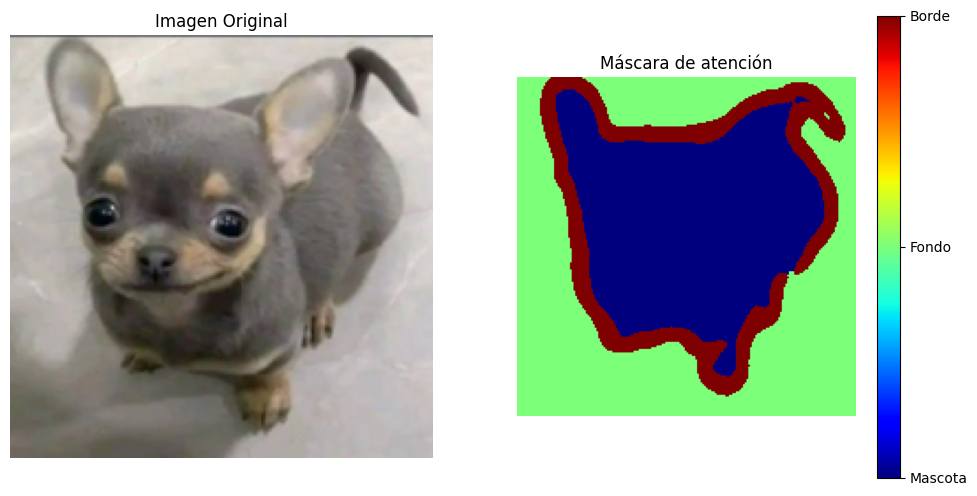

In [61]:
predict(Roland_INFINITY, "../../PetImages/Old_DS/Dog/", "Nata_perro.jpg", device)